**no care was taken to make sure this is theoretically/quantitatively correct** for a first pass. Produces uneven illumination (or uneven autofluorescence/background depending on how it's modified) and adds some shot-like noise on top of this to corrupt the signal. The goal is to simulate lower signal data, since our real starting sample data has high contrast and high SNR. 

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import scipy.misc
import scipy.ndimage
import random
from tifffile import imsave
from skimage.io import imread

In [3]:
fname_prefix = "wtDMSO"
Git_commit_id = "0c6a19ef14466a53594ab33c66112239bca0c392"
#parameters to be used later
illumination_unevenness = 0.8 #modifies the sigma determining the illumination artifact
illumination_unevenness_power = 3
mean_dark_current = 0.2*10**3 
dark_current_std = 100
percent_dead_pix = 0.1
bit_depth_save = 16
signal_lower_factor = 1 #divide the raw signal by this before starting
resize_im_factor = 2.5 #make image smaller by this factor
autofluorescence = 10**3 #background that is influenced by uneven illumination pattern

In [7]:
from skimage.io import imread
raw = imread('20170601-ROCK-vinc/20170601-WT-DMSO-1.tif')

In [8]:
raw.shape

(1024, 1024, 3)

**user input** record the number of z-slices

In [10]:
zs = int(raw.shape[2]/resize_im_factor)

In [13]:
im = raw/signal_lower_factor
im.shape

(1024, 1024, 3)

In [12]:
mid_index = int(im.shape[1]/2)
print(mid_index)

NameError: name 'im' is not defined

In [325]:
#crudely simulate additive z-dependent autofluorescent signal
if autofluorescence != 0 :
#     af = np.ones(im.shape)
#     for z in range (0,zs-1):
#         af[z,:,:,:] = af[z,:,:,:]*autofluorescence*z/zs
#     im = im + af
    im  = im + autofluorescence*np.ones(im.shape)

In [326]:
plt.imshow(im[3,:,:,2], vmin = 0, vmax = im.max()*0.5)
im.max()

In [327]:
im.shape

In [328]:
#crudely simulate uneven illumination

#get parameters that are the same across all of the channels and slices
dim1 = im.shape[1]
dim2 = im.shape[2]

def gaussian(x, mu, sigma):
            return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))
mu = mid_index
sigma = mid_index*illumination_unevenness
gauss = gaussian(np.linspace(0, dim1, dim2), mu, sigma)

im_temp = np.zeros([dim1,dim2])

noiseD1 = np.zeros([dim1, dim2])
for x in range(0, dim1):
            noiseD1[:,x] = gauss
illumination = np.power(noiseD1.transpose()*noiseD1 , illumination_unevenness_power/2)

for Z in range(0,im.shape[0]):
    for ch in range(0,im.shape[3]):
        im[Z,:,:,ch] = illumination*im[Z,:,:,ch]
        
plt.imshow(im[3,:,:,2], vmin = 0, vmax = im[3,:,:,2].max()*0.2)

In [329]:
# plt.imshow(illumination)
im.shape
plt.imshow(im[3,:,:,2], vmin = 0, vmax = im[3,:,:,2].max()*0.2)

In [330]:
#add dark/thermal noise, uniform across image and normally distributed
#not technically correct, noise should come from dark current shot noise
for Z in range(0,im.shape[0]):
    for ch in range(0,im.shape[3]):
        dark_current = np.random.normal(mean_dark_current, dark_current_std, [dim1,dim2])
        im[Z,:,:,ch] = im[Z,:,:,ch] + dark_current


In [331]:
#pretend this is a ccd or scmos and add some dead pixels
num_dead = int(percent_dead_pix*dim1*dim2/100)

for Z in range(0,raw.shape[0]):
    for ch in range(0,raw.shape[3]):
        idxs = random.sample(list(np.arange(dim1*dim2)),num_dead)
        idx_bool = np.zeros([1,(dim1)*(dim2)], dtype=bool)
        idx_bool[0,np.array(idxs)] = True
        idx2d_bool = np.reshape(idx_bool, (dim1, dim2))
        im[Z,idx2d_bool,ch] = 0

In [332]:
#plt.imshow(noisy[3,300:500,300:500,2], vmin = 0, vmax = noisy.max()*0.0001)
plt.imshow(im[3,:,:,2], vmin = 0, vmax = noisy.max()*0.5)

In [333]:
im = np.uint16(im/im.max() * (2**bit_depth_save - 1 ))
imsave("../data/confocal_drug_panel/" + fname_prefix + ".tif",im)
im.shape

In [334]:
#write json file for the sample modified dataset
import json
meta = {'cell_type': 'fibroblast', 'channels': ["your_fav_protein", "nucleus", "actin"], 'pixel_size': [0.3459442,0.3459442,0.7694383], 'axes': ['ZXYTC'],'raw_data_date': ['add_this'], 'image_preprocessing_done': "Noise_generator.ipynb", "GitCommitId=" + Git_commit_id]}
with open("../data/confocal_drug_panel/" + fname_prefix + "_metadata.json", 'w') as f:
    json.dump(meta, f)

9081.92381249
39321.0


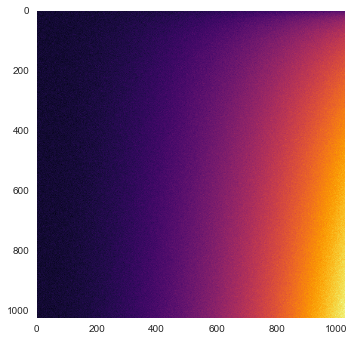

In [130]:
#dump of code from 6/2017 to generate uneven illumination patterns
from skimage.io import imread
illum_intensity = 0.2 #inverse of intensity

wt_data = imread(data_path + "20170601-WT-DMSO-1-raw.tif")
vinc_data = imread(data_path + "20170601-vincKO-DMSO-1-raw.tif")

dim_skew = 1
im = vinc_data.copy()/2


illum_bg = np.zeros( wt_data[:,:,0].shape )
for x in range(0,1023):
    for y in range(0,1023):
        illum_bg[y,x] = x**2 * y**0.3

illum_bg = illum_bg / illum_bg.max()
illum_bg = illum_bg + np.random.normal(illum_intensity,illum_intensity/10,illum_bg.shape)
illum_bg = illum_bg / illum_bg.max()

illum_bg[illum_bg<=0] = 1
illum_bg = illum_bg * im.max() + im.max() * 0.2

plt.imshow(illum_bg)
print(illum_bg.min())
print(illum_bg.max())

im[:,:,dim_skew] = (im[:,:,dim_skew] + im.max() * 0.2) * illum_bg
im[:,:,dim_skew] = im[:,:,dim_skew] - im[:,:,dim_skew].min()
from tifffile import imsave
im[:,:,dim_skew] = np.uint16(im[:,:,dim_skew]/im[:,:,dim_skew].max() * (2**16 - 1 ))
imsave(data_path + "20170601-vincKO-DMSO-1-noised.tif",im)

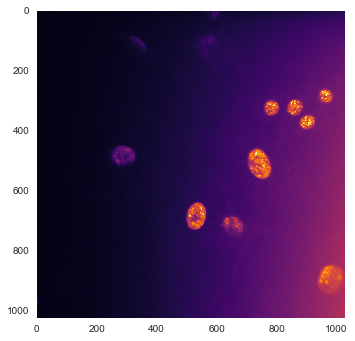

In [131]:
plt.imshow(im_save[:,:,dim_skew], vmax = 50000)

In [53]:
astype?

Object `astype` not found.


In [123]:
#dump of code to generate some nice metadata files

import json
meta = {'cell_type': 'MEF', 'channels': ["pax", "nucleus", "actin"], 'pixel_size': [0.2196471,0.2196471], 'axes': ['XYC'],'raw_data_date': ['2017-06-01'], 'image_preprocessing_done': "NA"}
with open(data_path + "20170601-vincKO-DMSO-1.json", 'w') as f:
    json.dump(meta, f)

In [5]:
data_path = "../data/20170601-ROCK-vinc/"

In [7]:

sns.set_style('dark', rc={'image.cmap':'inferno'})